<a href="https://colab.research.google.com/github/TivoGatto/Thesis/blob/master/Two%20Stage%20VAE/Two_Stage_VAE_(learn_gamma)_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# LIBRARIES
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Model
from keras.layers import Input, Conv2D, BatchNormalization, ReLU, Dense, Flatten, Reshape, Conv2DTranspose, Lambda, Concatenate
from keras.callbacks import Callback
from keras.datasets import cifar10
import keras.backend as K

from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

In [ ]:
# Parameters
input_dim = (32, 32, 3)
latent_dim = 128

epochs = 150
batch_size = 100

initial_lr = 1e-4
halve_at_epoch_1 = 80
halve_at_epoch_2 = 120

global beta
beta = 1

TRAIN = False
SECOND_TRAIN = True

In [ ]:
# Functions
def vae_loss(z_mean, z_log_var):
    def loss(x_true, x_pred):
        x_true = K.reshape(x_true, (-1, np.prod(input_dim)))
        x_pred = K.reshape(x_pred, (-1, np.prod(input_dim)))

        L_rec = 0.5 * K.sum(K.square(x_true - x_pred), axis=-1)
        L_KL = 0.5 * K.sum(K.square(z_mean) + K.exp(z_log_var) - 1 - z_log_var, axis=-1)

        return K.mean(L_rec + beta * L_KL)
    return loss

def recon(x_true, x_pred):
    x_true = K.reshape(x_true, (-1, np.prod(input_dim)))
    x_pred = K.reshape(x_pred, (-1, np.prod(input_dim)))

    return K.mean(0.5 * K.sum(K.square(x_true - x_pred), axis=-1))

def KL(z_mean, z_log_var):
    def kl(x_true, x_pred):
        return K.mean(0.5 * K.sum(K.square(z_mean) + K.exp(z_log_var) - 1 - z_log_var, axis=-1))
    return kl

def sampling(args):
    z_mean, z_log_var = args
    eps = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim))

    return z_mean + K.exp(0.5 * z_log_var) * eps

class UpdateBeta(Callback):
    def on_epoch_end(self, epoch, logs):
        global beta
        val = logs['recon']
        beta = val / (32 * 32 * 3)

        print(' - Beta = ' + str(beta))

In [ ]:
# Dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train = x_train.astype('float32')/255
x_test  = x_test.astype('float32')/255

print('x_train shape: ' + str(x_train.shape))
print('x_test shape: ' + str(x_test.shape))

170500096/170498071 [==============================] - 11s 0us/step
x_train shape: (50000, 32, 32, 3)
x_test shape: (10000, 32, 32, 3)


In [ ]:
# Model Architecture
# ENCODER
x = Input(shape=input_dim) # Shape (32, 32, 3)

h = Conv2D(64, 4, strides=(2, 2), padding='same')(x) # Shape (16, 16, 64)
h = BatchNormalization()(h)
h = ReLU()(h)

h = Conv2D(128, 4, strides=(2, 2), padding='same')(h) # Shape (8, 8, 128)
h = BatchNormalization()(h)
h = ReLU()(h)

h = Conv2D(256, 4, strides=(2, 2), padding='same')(h) # Shape (4, 4, 256)
h = BatchNormalization()(h)
h = ReLU()(h)

h = Conv2D(512, 4, strides=(2, 2), padding='same')(h) # Shape (2, 2, 512)
h = BatchNormalization()(h)
h = ReLU()(h)

h = Flatten()(h)

z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)
z = Lambda(sampling)([z_mean, z_log_var])

encoder = Model(x, [z, z_mean, z_log_var])

# DECODER
z_in = Input(shape=(latent_dim, ))

h = Dense(4 * 4 * 512)(z_in)
h = Reshape((4, 4, 512))(h)
h = BatchNormalization()(h)
h = ReLU()(h)

h = Conv2DTranspose(256, 4, strides=(2, 2), padding='same')(h) # Shape (4, 4, 256)
h = BatchNormalization()(h)
h = ReLU()(h)

h = Conv2DTranspose(128, 4, strides=(2, 2), padding='same')(h) # Shape (8, 8, 128)
h = BatchNormalization()(h)
h = ReLU()(h)

h = Conv2DTranspose(64, 4, strides=(2, 2), padding='same')(h) # Shape (16, 16, 64)
h = BatchNormalization()(h)
h = ReLU()(h)

x_decoded = Conv2DTranspose(3, 2, strides=(1, 1), padding='same', activation='sigmoid')(h) # Shape (32, 32, 3)

decoder = Model(z_in, x_decoded)

# VAE
x_recon = decoder(z)

vae = Model(x, x_recon)

# Compile model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import PiecewiseConstantDecay
steps_per_epoch = 45000 / batch_size
lr_schedule = PiecewiseConstantDecay([steps_per_epoch * halve_at_epoch_1, steps_per_epoch * halve_at_epoch_2], 
                                     [initial_lr, initial_lr/2, initial_lr/4])
optimizer = Adam(learning_rate=lr_schedule)

vae.compile(optimizer=optimizer, loss=vae_loss(z_mean, z_log_var), metrics=[recon, KL(z_mean, z_log_var)])

In [ ]:
total_hist = []
if TRAIN:
    for i in range(15):
        # Fit model
        vae.compile(optimizer=optimizer, loss=vae_loss(z_mean, z_log_var), metrics=[recon, KL(z_mean, z_log_var)])
        hist = vae.fit(x_train, x_train, batch_size=batch_size, epochs=10, verbose=1, validation_split=0.1, callbacks=[UpdateBeta()])

        total_hist.append(hist)
    # Save model
    vae.save_weights('twostage_VAE_CIFAR10_learngamma.h5')
else:
    vae.load_weights('twostage_VAE_CIFAR10_learngamma.h5')

# Save training history

In [ ]:
if TRAIN:
    loss = []
    recon = []
    kl = []
    val_loss = []
    val_recon = []
    val_kl = []
    for hist in total_hist:
        loss += hist.history['loss']
        recon += hist.history['recon']
        kl += hist.history['kl']

        val_loss += hist.history['val_loss']
        val_recon += hist.history['val_recon']
        val_kl += hist.history['val_kl']

    loss = np.asarray(loss)
    recon = np.asarray(recon)
    kl = np.asarray(kl)
    val_loss = np.asarray(val_loss)
    val_recon = np.asarray(val_recon)
    val_kl = np.asarray(val_kl)
    from numpy import savetxt
    # save history
    data = np.asarray([loss, recon, kl, val_loss, val_recon, val_kl])
    savetxt('naive_VAE_CIFAR10_learngamma.csv', data, delimiter=',')

In [ ]:
# Second Stage VAE

# Loss
def second_stage_loss(u_mean, u_log_var):
    def loss(x_true, x_pred):
        L_rec = 0.5 * K.sum(K.square(x_true - x_pred), axis=-1)
        L_KL = 0.5 * K.sum(K.square(u_mean) + K.exp(u_log_var) - 1 - u_log_var, axis=-1)

        return K.mean(L_rec + second_beta * L_KL)
    return loss

def second_recon(x_true, x_pred):
    return K.mean(0.5 * K.sum(K.square(x_true - x_pred), axis=-1))

def second_KL(z_mean, z_log_var):
    def kl(x_true, x_pred):
        return K.mean(0.5 * K.sum(K.square(z_mean) + K.exp(z_log_var) - 1 - z_log_var, axis=-1))
    return kl

def second_stage_sampling(args):
    u_mean, u_log_var = args
    eps = K.random_normal(shape=(batch_size, latent_dim))

    return u_mean + eps * K.exp(0.5 * u_log_var)

second_beta = 0.05

# Encoder
intermediate_dim = 1024

z = Input(shape=(latent_dim, ))

h = Dense(intermediate_dim, activation='relu')(z)
h = Dense(intermediate_dim, activation='relu')(h)
h = Dense(intermediate_dim, activation='relu')(h)

h = Concatenate()([h, z])

u_mean = Dense(latent_dim)(h)
u_log_var = Dense(latent_dim)(h)

u = Lambda(second_stage_sampling)([u_mean, u_log_var])
second_encoder = Model(z, [u, u_mean, u_log_var])

# Decoder
u_in = Input(shape=(latent_dim, ))

h = Dense(intermediate_dim, activation='relu')(u_in)
h = Dense(intermediate_dim, activation='relu')(h)
h = Dense(intermediate_dim, activation='relu')(h)

h = Concatenate()([h, u_in])

z_decoded = Dense(latent_dim)(h)
second_decoder = Model(u_in, z_decoded)

# VAE
z_reconstructed = second_decoder(u)
second_vae = Model(z, z_reconstructed)

# Compile model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import PiecewiseConstantDecay
steps_per_epoch = 45000 / batch_size
lr_schedule = PiecewiseConstantDecay([steps_per_epoch * halve_at_epoch_1, steps_per_epoch * halve_at_epoch_2], 
                                     [initial_lr, initial_lr/2, initial_lr/4])
optimizer = Adam(learning_rate=lr_schedule)
second_vae.compile(optimizer=optimizer, loss=second_stage_loss(u_mean, u_log_var), metrics=[second_recon, second_KL(u_mean, u_log_var)])

In [ ]:
# Generate second stage Dataset
z_train = encoder.predict(x_train)[0]
z_test = encoder.predict(x_test)[0]

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


In [ ]:
if SECOND_TRAIN:
    # Fit model
    second_vae.compile(optimizer=optimizer, loss=second_stage_loss(u_mean, u_log_var), metrics=[second_recon, second_KL(u_mean, u_log_var)])
    second_hist = second_vae.fit(z_train, z_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_split=0.1)

    # Save model
    second_vae.save_weights('second_twostage_VAE_CIFAR10_learngamma.h5')
else:
    second_vae.load_weights('second_twostage_VAE_CIFAR10_learngamma.h5')

Train on 45000 samples, validate on 5000 samples
Epoch 1/150
45000/45000 [==============================] - 2s 40us/sample - loss: 34.6800 - second_recon: 27.3050 - kl: 147.4991 - val_loss: 19.7749 - val_second_recon: 10.2919 - val_kl: 189.6610
Epoch 2/150
45000/45000 [==============================] - 2s 37us/sample - loss: 17.7218 - second_recon: 8.0804 - kl: 192.8277 - val_loss: 16.4380 - val_second_recon: 6.8922 - val_kl: 190.9174
Epoch 3/150
45000/45000 [==============================] - 2s 37us/sample - loss: 15.8925 - second_recon: 6.2591 - kl: 192.6676 - val_loss: 15.4140 - val_second_recon: 5.8074 - val_kl: 192.1300
Epoch 4/150
45000/45000 [==============================] - 2s 37us/sample - loss: 15.1563 - second_recon: 5.5867 - kl: 191.3915 - val_loss: 14.9217 - val_second_recon: 5.4916 - val_kl: 188.6014
Epoch 5/150
45000/45000 [==============================] - 2s 37us/sample - loss: 14.6959 - second_recon: 5.1739 - kl: 190.4387 - val_loss: 14.6639 - val_second_recon: 5.332

In [ ]:
if SECOND_TRAIN: 
    loss = second_hist.history['loss']
    recon = second_hist.history['second_recon']
    kl = second_hist.history['kl']

    val_loss = second_hist.history['val_loss']
    val_recon = second_hist.history['val_second_recon']
    val_kl = second_hist.history['val_kl']

    from numpy import savetxt
    # save history
    data = np.asarray([loss, recon, kl, val_loss, val_recon, val_kl])
    savetxt('second_twostage_VAE_CIFAR10_learngamma.csv', data, delimiter=',')

# Generation and Reconstruction

Now we have two VAE network: \\
1) u <- p(u) = N(0, I) \\
2) z <- q(z) = E_p(u)[q(z|u)] \\
3) x <- p(x) = E_q(z)[p(x|z)] \\

And we can use them to generate new samples.

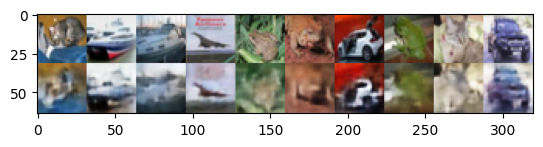

In [ ]:
# Reconstruction

"""
Here we don't need to use the second stage VAE, 'cause we don't use q(z)
"""
n = 10
digit_size = input_dim[0]

x_recon = vae.predict(x_test, batch_size=batch_size)
figure = np.zeros((2 * digit_size, n * digit_size, 3))

for i in range(n):
    figure[:digit_size, i * digit_size: (i+1) * digit_size, :] = x_test[i]
    figure[digit_size:, i * digit_size: (i+1) * digit_size, :] = x_recon[i]

plt.style.use('default')
plt.imshow(figure)
plt.savefig('twostage_VAE_CIFAR10_learngamma_reconstruction.png')
plt.show()

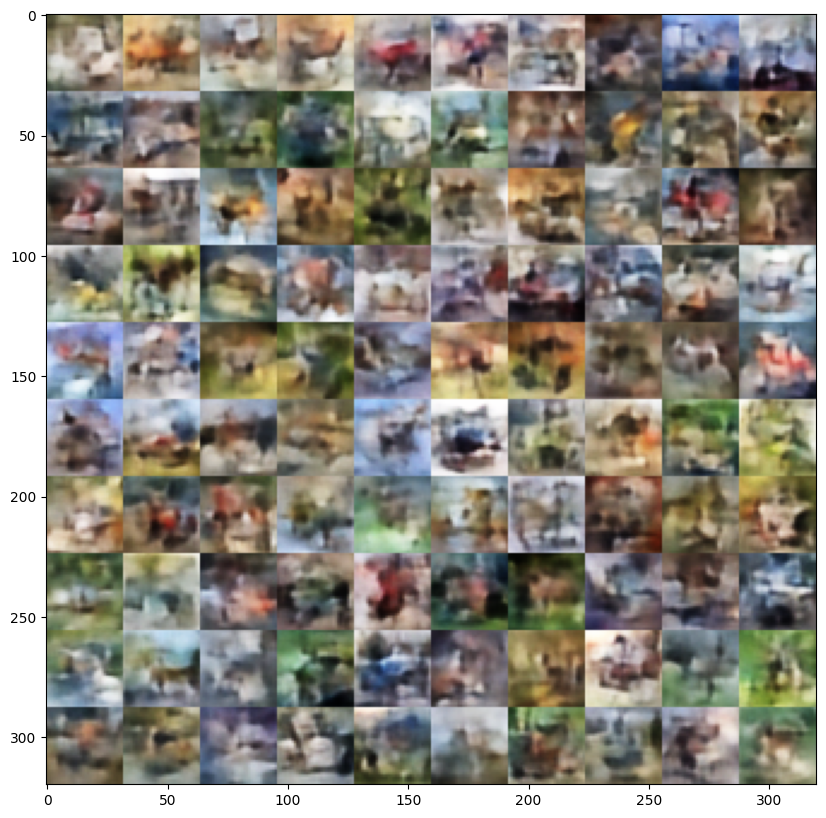

In [ ]:
# Generation
n = 10 #figure with n x n digits
digit_size = 32
figure = np.zeros((digit_size * n, digit_size * n, 3))
# we will sample n points randomly sampled

"""
We want to sample z from q(z) = E_p(u)[q(z|u)]
p(u) = N(0, I)
"""

u_sample = np.random.normal(size=(n**2, latent_dim), scale=1)
z_sample = second_decoder.predict(u_sample, batch_size=batch_size)
for i in range(n):
    for j in range(n):
        x_decoded = decoder.predict(np.array([z_sample[i + n * j]]))
        figure[i * digit_size: (i + 1) * digit_size,
            j * digit_size: (j + 1) * digit_size, :] = x_decoded

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.savefig('twostage_VAE_CIFAR10_learngamma_generation.png')
plt.show()

# Interpolation

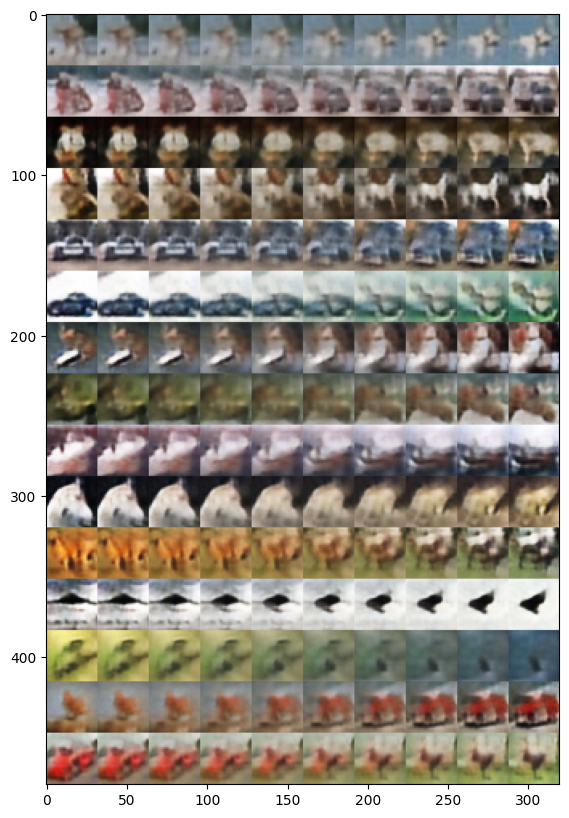

In [ ]:
T = 10
N = 15

s = 10
k = 100

X_final = [0] * N
for n in range(N):
    x_a = x_test[n + s]
    x_b = x_test[n + k]

    z_a = encoder.predict(np.reshape(x_a, (1, 32, 32, 3)))[0]
    z_b = encoder.predict(np.reshape(x_b, (1, 32, 32, 3)))[0]


    X = [0] * T
    for i in range(T):
        t = i/T
        z = t * z_a + (1 - t) * z_b

        X[i] = decoder.predict(z)
    
    X_final[n] = X

digit_size = 32
figure = np.zeros((N * digit_size, T * digit_size, 3))
for n in range(N):
    for i in range(T):
        figure[n * digit_size : (n+1) * digit_size, i * digit_size : (i+1) * digit_size, :] = X_final[n][i][0, :, :, :]

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.savefig('twostage_VAE_CIFAR10_learngamma_interpolation.png')
plt.show()

# Nearest Neighbour

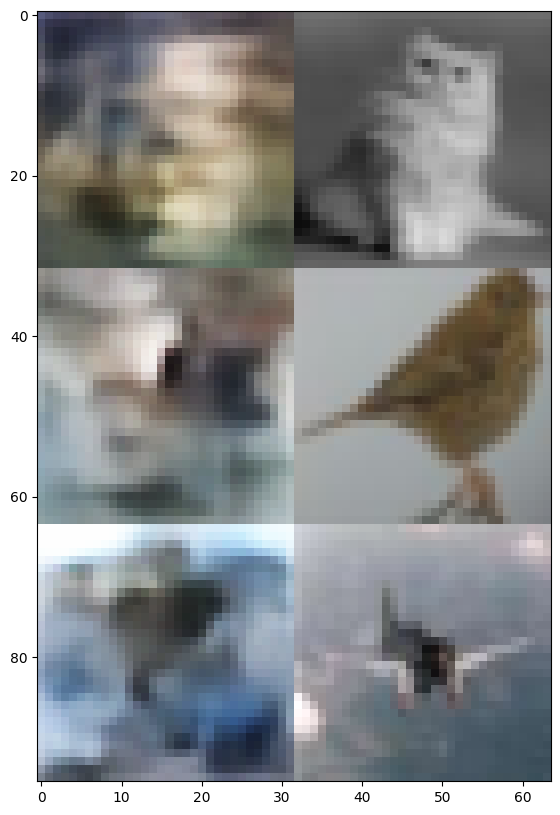

In [ ]:
# We want to investigate overfitting
def get_distance(x, y_vec):
    digit_size = x.shape[0]
    x = np.reshape(x, (digit_size**2*3, ))
    y_vec = np.reshape(y_vec, (-1, digit_size**2*3, ))

    res = np.zeros((y_vec.shape[0], ))
    for j in range(y_vec.shape[0]):
        res[j] = np.mean(np.square(x - y_vec[j]))

    return res

N = 3 # Images we need to check
digit_size = 32
u_sample = np.random.normal(size=(N, latent_dim), scale=1)
z = second_decoder.predict(u_sample, batch_size=batch_size)
x_gen = decoder.predict(z)
figure = np.zeros((N * digit_size, 2 * digit_size, 3))
for i in range(N):
    x = x_gen[i]
    distances = get_distance(x, x_train)
    m = np.min(distances)
    i_m = np.argmin(distances)

    figure[i * digit_size : (i+1) * digit_size, : digit_size, :] = x
    figure[i * digit_size : (i+1) * digit_size, digit_size :] = x_train[i_m]

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.savefig('twostage_VAE_CIFAR10_learngamma_NN.png')
plt.show()

# Metrics Evaluation

In [ ]:
import numpy as np
from scipy.linalg import sqrtm
from keras.applications.inception_v3 import InceptionV3
import tensorflow as tf
#from keras.applications.inception_v3 import preprocess_input
#from skimage.transform import resize
#from tensorflow.keras.models import load_model
#import os
#from matplotlib import pyplot

# prepare the inception v3 model
model = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3), weights='imagenet')

def get_inception_activations(inps, batch_size=100):
    n_batches = inps.shape[0]//batch_size
    act = np.zeros([inps.shape[0], 2048], dtype = np.float32)
    for i in range(n_batches):
        inp = inps[i * batch_size:(i + 1) * batch_size]
        inpr = tf.image.resize(inp, (299, 299))
        act[i * batch_size:(i + 1) * batch_size] = model.predict(inpr,steps=1)
        
        print('Processed ' + str((i+1) * batch_size) + ' images.')
    return act

def get_fid(images1, images2):
    print(images1.shape)
    print(images2.shape)
    print(type(images1))
    # calculate activations
    act1 = get_inception_activations(images1,batch_size=100)
    #print(np.shape(act1))
    act2 = get_inception_activations(images2,batch_size=100)
    # compute mean and covariance statistics
    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
    # calculate sum squared difference between means
    ssdiff = np.sum((mu1 - mu2)**2.0)
    # compute sqrt of product between cov
    covmean = sqrtm(sigma1.dot(sigma2))
    # check and correct imaginary numbers from sqrt
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    # calculate score
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

u_sample = np.random.normal(0, 1, size=(x_test.shape[0], latent_dim))
z_sample = second_decoder.predict(u_sample)
x_gen = decoder.predict(z_sample)

fid = get_fid(x_test, x_gen)
print('\n FID: %.3f' % fid)

87916544/87910968 [==============================] - 1s 0us/step
(10000, 32, 32, 3)
(10000, 32, 32, 3)
<class 'numpy.ndarray'>
Processed 100 images.
Processed 200 images.
Processed 300 images.
Processed 400 images.
Processed 500 images.
Processed 600 images.
Processed 700 images.
Processed 800 images.
Processed 900 images.
Processed 1000 images.
Processed 1100 images.
Processed 1200 images.
Processed 1300 images.
Processed 1400 images.
Processed 1500 images.
Processed 1600 images.
Processed 1700 images.
Processed 1800 images.
Processed 1900 images.
Processed 2000 images.
Processed 2100 images.
Processed 2200 images.
Processed 2300 images.
Processed 2400 images.
Processed 2500 images.
Processed 2600 images.
Processed 2700 images.
Processed 2800 images.
Processed 2900 images.
Processed 3000 images.
Processed 3100 images.
Processed 3200 images.
Processed 3300 images.
Processed 3400 images.
Processed 3500 images.
Processed 3600 images.
Processed 3700 images.
Processed 3800 images.
Processe

### Deactivated Latent Variables, Variance Loss and Variance Law


In [ ]:
def count_deactivated_variables(z_var, treshold = 0.8):
    z_var = np.mean(z_var, axis=0)

    return np.sum(z_var > treshold)

def loss_variance(x_true, x_recon):
    x_true = np.reshape(x_true, (-1, np.prod(x_true.shape[1:])))
    x_recon = np.reshape(x_recon, (-1, np.prod(x_recon.shape[1:])))

    var_true = np.mean(np.var(x_true, axis=1), axis=0)
    var_recon = np.mean(np.var(x_recon, axis=1), axis=0)

    return np.abs(var_true - var_recon)

########################################################################################################################
# SHOW THE RESULTS
########################################################################################################################

_, z_mean, z_log_var = encoder.predict(x_test, batch_size=batch_size)
z_var = np.exp(z_log_var)
n_deact = count_deactivated_variables(z_var)
print('We have a total of ', latent_dim, ' latent variables. ', count_deactivated_variables(z_var), ' of them are deactivated')

var_law = np.mean(np.var(z_mean, axis=0) + np.mean(z_var, axis=0))
print('Variance law has a value of: ', var_law)

x_recon = vae.predict(x_train, batch_size=batch_size)
print('We lost ', loss_variance(x_test, x_recon), 'Variance of the original data')

We have a total of  128  latent variables.  0  of them are deactivated
Variance law has a value of:  0.975566
We lost  0.002881281 Variance of the original data


In [ ]:
# We want to verify if q(z) = p(z).

# Moments Matching
# Generate samples from q(z) and for p(z)
# p(z) = N(0, I)
# q(z) = E_q(x)[q(z|x)]
#
# For every moment we compare the moments
n = len(x_test)

u_samples = np.random.normal(size=(n, latent_dim))
p_samples = second_decoder.predict(u_samples)
q_samples = encoder.predict(x_test, batch_size=batch_size)


from scipy.stats import moment
# First moment matching:
p_first_moment = np.mean(np.mean(p_samples, axis=0))
q_first_moment = np.mean(np.mean(q_samples, axis=0))

print("\n")
print("First moment of p(z): " + str(p_first_moment))
print("First moment of q(z): " + str(q_first_moment))
print("\n")

# Second moment matching:
p_second_moment = np.mean(np.var(p_samples, axis=0))
q_second_moment = np.mean(np.var(q_samples, axis=0))

print("\n")
print("Second moment of p(z): " + str(p_second_moment))
print("Second moment of q(z): " + str(q_second_moment))
print("\n")

# Thid moment matching:
p_third_moment = np.mean(moment(p_samples, moment=3, axis=0))
q_third_moment = np.mean(moment(q_samples, moment=3, axis=0))

print("\n")
print("Third moment of p(z): " + str(p_third_moment))
print("Third moment of q(z): " + str(q_third_moment))
print("\n")



First moment of p(z): -0.0024588369
First moment of q(z): -1.9536457




Second moment of p(z): 0.8511871
Second moment of q(z): 7.9608197




Third moment of p(z): 0.0044588884
Third moment of q(z): -16.992014




# MMD

In [ ]:
# To verify that q(z) = p(z) we can also use MMD

def compute_kernel(x, y):
    return np.exp(-np.mean(np.square(x - y), axis=-1))

def compute_mmd(x, y):
    x_kernel = compute_kernel(x, x)
    y_kernel = compute_kernel(y, y)
    xy_kernel = compute_kernel(x, y)

    return np.mean(x_kernel) + np.mean(y_kernel) - 2 * np.mean(xy_kernel) 

u_samples = np.random.normal(size=(len(x_test), latent_dim))
z_p = second_decoder.predict(u_samples) # sample from p(z)
z_q = encoder.predict(x_test, batch_size=batch_size)[0]  # sample from q(z)

z_p = z_p.astype('float32')
z_q = z_q.astype('float32')

mmd = compute_mmd(z_p, z_q)
print('MMD between p(z) and q(z) is ' + str(mmd))

MMD between p(z) and q(z) is 1.6494112312793732
